In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import geopandas as gpd

In [2]:
inters_key = pd.read_csv('./data/interseccion_radio_circuitos.csv', index_col=0)

In [3]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

#Esto es para extraer las viviendas, hogares y personas de los partidos (DPTOs) en cuestion.
# seleccion_DPTOS y usecols nos sirven para no cargar data innecesaria.
radio_ref = pd.read_csv('./../Datos_censo/Radios_censales/radio_ref.csv')
VIVIENDA = dd.read_csv('./../../Desktop/extracted_/VIVIENDA.csv', sep = ';', 
                       usecols = ['VIVIENDA_REF_ID', 'RADIO_REF_ID', 'TIPVV', 'V01'])
VIVIENDA = VIVIENDA.merge(radio_ref[['RADIO_REF_ID', 'radio', 'DPTO', 'PROV']], how = 'left')
VIVIENDA = VIVIENDA.loc[VIVIENDA.PROV.isin([2, 6])].sample(.1) # 6.811.463 de viviendas en BA

with ProgressBar():
    df = VIVIENDA.compute()

[########################################] | 100% Completed | 13.8s


In [4]:
list_ = []
for dpto in inters_key.DPTO.unique():
    list_dpto = []
    print(dpto)
    inters_key_dpto = inters_key.loc[(inters_key.DPTO == dpto)]
    for circ in inters_key_dpto.circuito.unique():
        list_circ = []
#         print(circ)
        # Radios incluidos totalmente en el circuito
        inters_key_circ_total =  inters_key_dpto.loc[(inters_key_dpto.circuito == circ) & (inters_key_dpto.pertenencia == 1)]
        fully_contained_radios = inters_key_circ_total['LINK'].values
        viviendas = df.loc[df.radio.isin(fully_contained_radios)]
        if len(viviendas) > 1:
            list_circ += [viviendas] #samplear segun cuanto de ese radio pertenece al circuito
        
        # Radios incluidos parcialmente
        inters_key_circ_parte =  inters_key_dpto.loc[(inters_key_dpto.circuito == circ) & (inters_key_dpto.pertenencia < 1)]
        for i, r in inters_key_circ_parte.iterrows():
            viviendas = df.loc[df.radio == r['LINK']]
            if len(viviendas) > 1:
                list_circ += [viviendas.sample(frac = r['pertenencia'])] #samplear segun cuanto de ese radio pertenece al circuito    

        try:
            result_circuito = pd.concat(list_circ)
            result_circuito['circuito'] = circ
            list_dpto += [result_circuito]
        except:
            print('issue on dpto '+str(dpto))
    
    result_dpto = pd.concat(list_dpto)
    result_dpto['DPTO'] = dpto
    list_ += [result_dpto]
result = pd.concat(list_)

6049
6056
6063
6070
issue on dpto 6070
6084
6091
6098
6119
6126
6147
6140
6014
6007
62007
6035
62014
86028
6077
6105
6161
6168
2014
2007
6028
22007
6175
14021
30008
6021
6042
74007
6154
6189
6182
6112
2013
2012
2002
2011
2015
2001
2003
2005
2006
2010
2004
6515
6357
6539
6196
74021
6784
6791
6798
6553
6581
6547
6560
86119
6763
6505
6511
22091
50070
6518
6588
issue on dpto 6588
22105
issue on dpto 22105
62049
issue on dpto 62049
70063
issue on dpto 70063
82077
issue on dpto 82077
6595
6826
6833
6602
6609
6616
6623
6568
6651
6875
6490
6497
6658
6665
6441
6476
2009
2008
6882
6134
6203
6210
22028
74028
6231
6448
6224
6238
6260
6266
6270
6329
6336
6364
6413
issue on dpto 6413
issue on dpto 6413
issue on dpto 6413
50035
issue on dpto 50035
issue on dpto 50035
issue on dpto 50035
74049
issue on dpto 74049
issue on dpto 74049
issue on dpto 74049
6525
6483
6455
6462
54070
6638
6742
6532
18105
6648
6679
50084
66133
70084
86154
6778
6868
6805
6574
6840
6749
22140
6854
22168
54119
62091
70126
6644


In [5]:
# result.to_csv('./radio_circuito_key_example.csv')

In [6]:
result.shape

(821854, 8)

In [7]:
# Listo, tenemos la ubicacion de muchas viviendas en circuitos. Consigamos sus hogares y personas y contemos cuantos mayores de 16 hay.

HOGARES = dd.read_csv('./../../Desktop/extracted_/HOGAR.csv', sep = ';', 
#                       usecols = ['HOGAR_REF_ID', 'VIVIENDA_REF_ID'])
                      usecols = ['HOGAR_REF_ID', 'VIVIENDA_REF_ID', 'H05', 'H06', 'H07', 'H08',
       'H09', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'PROP', 'TOTPERS'])
HOGARES = HOGARES.loc[HOGARES.VIVIENDA_REF_ID.isin(result.VIVIENDA_REF_ID.unique())] # Las viviendas elegidas salen de los circuitos

with ProgressBar():
    HOGARES_sample = HOGARES['HOGAR_REF_ID'].values.compute()
    

merged_hogar = VIVIENDA.merge(HOGARES, on = 'VIVIENDA_REF_ID')#.merge(PERSONA_)

IX_TOT = merged_hogar.groupby('HOGAR_REF_ID').count().iloc[:, 0].reset_index()
IX_TOT.columns = ['HOGAR_REF_ID', 'IX_TOT']

merged_hogar = merged_hogar.merge(IX_TOT)

with ProgressBar():
    table = merged_hogar.compute()

# Approach: modify Census to fit EPH
table['V01'] = table['V01'].map({1:1, 2:6, 3:6, 4:2, 5:3, 6:4, 7:5, 8:6})
table['H06'] = table['H06'].map({1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:9})
table['H09'] = table['H09'].map({1:1, 2:2, 3:3, 4:4, 5:4, 6:4})
table['H16'] = table['H16'].clip(0, 9)
table['H14'] = table['H14'].map({1:1, 2:4, 3:2, 4:2, 5:4, 6:3, 7:4, 8:9})
table['H13'] = table['H13'].map({1:1, 2:2, 4:0})

# saber de que aglo es la persona. Se usa los resultados de cada aglo.
table = table.merge(radio_ref[['RADIO_REF_ID','AGLOMERADO']]) 

# in case it crashes
table.to_csv('./data/vivienda_hogar_step_save.csv', index = False)

 

[########################################] | 100% Completed | 44.8s
[########################################] | 100% Completed | 56.5s


In [8]:
PERSONA = dd.read_csv('./../../Desktop/extracted_/PERSONA.csv', sep = ';', 
#                       usecols = ['PERSONA_REF_ID', 'HOGAR_REF_ID', 'P03'])
                      usecols = ['PERSONA_REF_ID', 'HOGAR_REF_ID', 'P01', 'P02', 'P03', 'P05', 'P06',
       'P07', 'P12', 'P08', 'P09', 'P10', 'CONDACT'])
PERSONA = PERSONA.loc[PERSONA.HOGAR_REF_ID.isin(HOGARES_sample)]

with ProgressBar():
    PERSONA = PERSONA.compute()
    

table = table.merge(PERSONA, on = 'HOGAR_REF_ID')
table['P07'] = table['P07'].map({1:1, 2:2, 0:2})

# with ProgressBar():
#     df = table.compute()
    
table.to_csv('./data/vivienda_hogar_persona_step_save.csv', index = False)


[########################################] | 100% Completed |  1min 31.4s


In [9]:
set(table.columns).intersection(set(result.columns))
# result.nunique()

{'DPTO', 'PROV', 'RADIO_REF_ID', 'TIPVV', 'V01', 'VIVIENDA_REF_ID', 'radio'}

In [10]:
cicuito_pers = result.merge(table, on = ['DPTO', 'PROV', 'RADIO_REF_ID', 'TIPVV', 'V01', 'VIVIENDA_REF_ID', 'radio'])

# electores
cicuito_pers = cicuito_pers.loc[cicuito_pers.P03 > 15]

# dptos info
from unidecode import unidecode
DPTO = pd.read_csv('./../censo_geo/DPTO.csv', ';')[['DPTO', 'NOMDPTO']]
DPTO['dpto_merge'] = [unidecode(row) for row in DPTO['NOMDPTO'].str.lower()]
DPTO['dpto_merge'] = DPTO['dpto_merge'].str.replace('25', 'veinticinco').str.replace('9 ', 'nueve ')

#zafa porque es CABA y PBA, pero hay que mergear usando DPTO y PROV. Pasa que los ID de provs estan en dos sistemas, con lo cual es mas largo de acomodar
cicuito_pers = cicuito_pers.merge(DPTO[['DPTO', 'dpto_merge']], on = 'DPTO')
cicuito_pers.to_csv('./data/circuito_poblacion_sint.csv', index = False)

### Comparacion electores plot

In [11]:
votos = pd.read_csv('./../EleccionesARG/data/tablas_votos/VOTOS_2015_17_circ_cnt.csv', header = [0, 1], index_col=[0, 1, 2])
# votos = votos['ELECTORES'][['DN_2017']].reset_index()
poblacion = cicuito_pers.groupby(['dpto_merge', 'circuito']).count()[['PERSONA_REF_ID']].reset_index()

In [12]:
comparacion_electores = poblacion.merge(votos['ELECTORES'].reset_index(),
                left_on = ['dpto_merge', 'circuito'],
                right_on = ['dpto_merger_str', 'circuito']
               ).set_index(['dpto_merge', 'circuito'])[['PERSONA_REF_ID', 'DN_2015', 'paso_2017', 'DN_2017']]
comparacion_electores.sum()

PERSONA_REF_ID     1036198
DN_2015           14444796
paso_2017         14719653
DN_2017           15204835
dtype: int64

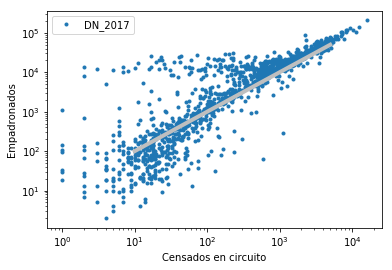

In [22]:
import matplotlib.pyplot as plt
% matplotlib inline
comparacion_electores.plot('PERSONA_REF_ID', 'DN_2017', marker = '.', linewidth = 0)
plt.xscale('log'); plt.yscale('log')
plt.plot([10, 5000], [100, 50000], ls="-", c=".75", lw = 4)
plt.xlabel('Censados en circuito')
plt.ylabel('Empadronados')
plt.show()

In [ ]:
# comparacion_electores[[ 'DN_2015', 'paso_2017', 'DN_2017']].div(comparacion_electores['poblacion'].values, 0)/2.